In [1]:
import sys
import os
import importlib
import random
from itertools import combinations

import numpy as np
import scipy
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import prettypyplot as pplt

import mdtraj as md

import ivac
import extq

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [3]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

In [23]:
%config InlineBackend.figure_format = "retina"

# Load data

In [4]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load("../../data/raw_feat/cv_dist_spin_anton2.npy"))
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy"))

cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)

traj_inds = util.split_indices(cv_trajs)
print(cv_arr.shape, sb_arr.shape)

(4150115, 2) (4150115, 60)


In [ ]:
sb_names = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_names.append(f"{r} C$_\\alpha$-{n} C$_\\alpha$")
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\gamma$")
        else:
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\delta$")
sb_models = np.load("../../data/models_centroids_feat2.npy")

In [6]:
rf161 = list(np.load("../../data/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load("../../data/raw_feat/rf161_anton2.npy"))
rf161_arr = np.concatenate(rf161)
print(rf161_arr.shape)

(4150115, 3)


In [21]:
ivac_trajs = np.load("../../data/raw_feat/ivac_less_feat_10-1000.npy", allow_pickle=True)
ivac_arr = np.concatenate(ivac_trajs)
ivac_models = np.load("../../data/models_ivac_less_feat_10-1000.npy")

In [7]:
# load committors
qp_du = np.load("../../data/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[8] # 50 ns
weights = np.load("../../data/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)

# Bin structures by committor

In [8]:
def bin_inds(q, qstep=0.05, low=0, hi=1):
    q_arr = np.concatenate(q)
    nsteps = round((hi - low) / qstep)
    all_inds = []
    steps = np.linspace(low, hi - qstep, nsteps)
    for i, s in enumerate(steps):
        q_inds = ((q_arr >= s) & (q_arr <= s + qstep)).nonzero()[0]
        all_inds.append(q_inds)
    return steps, all_inds

In [9]:
steps, q_inds = bin_inds(qp_du, qstep=0.2, low=0.4, hi=0.6)

In [56]:
sb_ids = [42, 47, 52, 53, 58, 59]
X = np.hstack((cv_arr, sb_arr[:, sb_ids], rf161_arr[:, 1:2]))

In [12]:
remove = {1282,
    1283,
    1284,
    1285,
    1286,
    1288,
    1289,
    1290,
    1187,
    1188,
    1189,
    1190,
    1191,
    1197,
    1198,
    1199,
    1203,
    1205,
    1206,
    1207,
    1211,
    1212,
    1213,
    1214,
    1215,
    1225,
    1226,
    1227,
    1228,
    1231,
    1232,
    1233,
    1236,
    1237,
    1238,
    1242,
    1245,
    1246,
    1252,
    1253,
    1260,
    1261,
    1262,
    1263,
    1266,
    1267,
    1268,
    1269,
    1270,
    1271,
    1272,
    1273,
    1274,
    1275,
    1276,
    1277,
    1278,
    1279,
}
files = []
for i in range(295):
    if (i + 1000) not in remove:
        files.append(f"/project/dinner/scguo/anton-old/civsd_{i}.dcd")
anton_files = []
for i in range(3, 119):
    if i == 82:
        pass
    anton_files.append(f"/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.{i}.dcd")

# $k$-medoids using minimum RMSD

In [13]:
import glob
import kmedoids

In [14]:
# load points (2000) at q_+ 0.5
topfile = "/project/dinner/scguo/ci-vsd/models/MD-clustering-center/civsd.psf"
tstate = md.load(glob.glob("../../data/q_bin/q5*.xtc"), top=topfile)

In [15]:
distances_noh = np.load("../../data/q_bin/q5_rmsd_noh_square.npy")

In [16]:
k = 2
c = kmedoids.fasterpam(distances_noh, k)

In [19]:
for m in c.medoids:
    i = m // 200
    j = m % 200
    with open(f"../../data/q_bin/q_5_{int(i)}.txt", mode='r') as f:
        lines = f.readlines()
        print(lines[int(j)].strip("\n"))

/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.103.dcd	5848
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.75.dcd	6847


In [19]:
for m in c.medoids:
    i = m // 200
    j = m % 200
    with open(f"../../data/q_bin/q_5_{int(i)}.txt", mode='r') as f:
        lines = f.readlines()
        print(lines[int(j)].strip("\n"))

/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.103.dcd	5848
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.75.dcd	6847


In [29]:
k = 3
c = kmedoids.fasterpam(distances_noh, k)
for m in c.medoids:
    i = m // 200
    j = m % 200
    with open(f"../../data/q_bin/q_5_{int(i)}.txt", mode='r') as f:
        lines = f.readlines()
        print(lines[int(j)].strip("\n"))

/project/dinner/scguo/anton-old/civsd_244.dcd	6580
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.75.dcd	6847
/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.105.dcd	6202


In [36]:
def convert(traj, frame, group="old"):
    if group == "old":
        for i in range(3_000_000):
            test_traj, test_frame = util.anton_frame(i)
            if traj == test_traj and frame == test_frame:
                return i
    elif group == "anton2":
        return 3_000_000 + (traj - 3) * 10001 + frame

In [37]:
convert(244, 6580)

2796580

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom


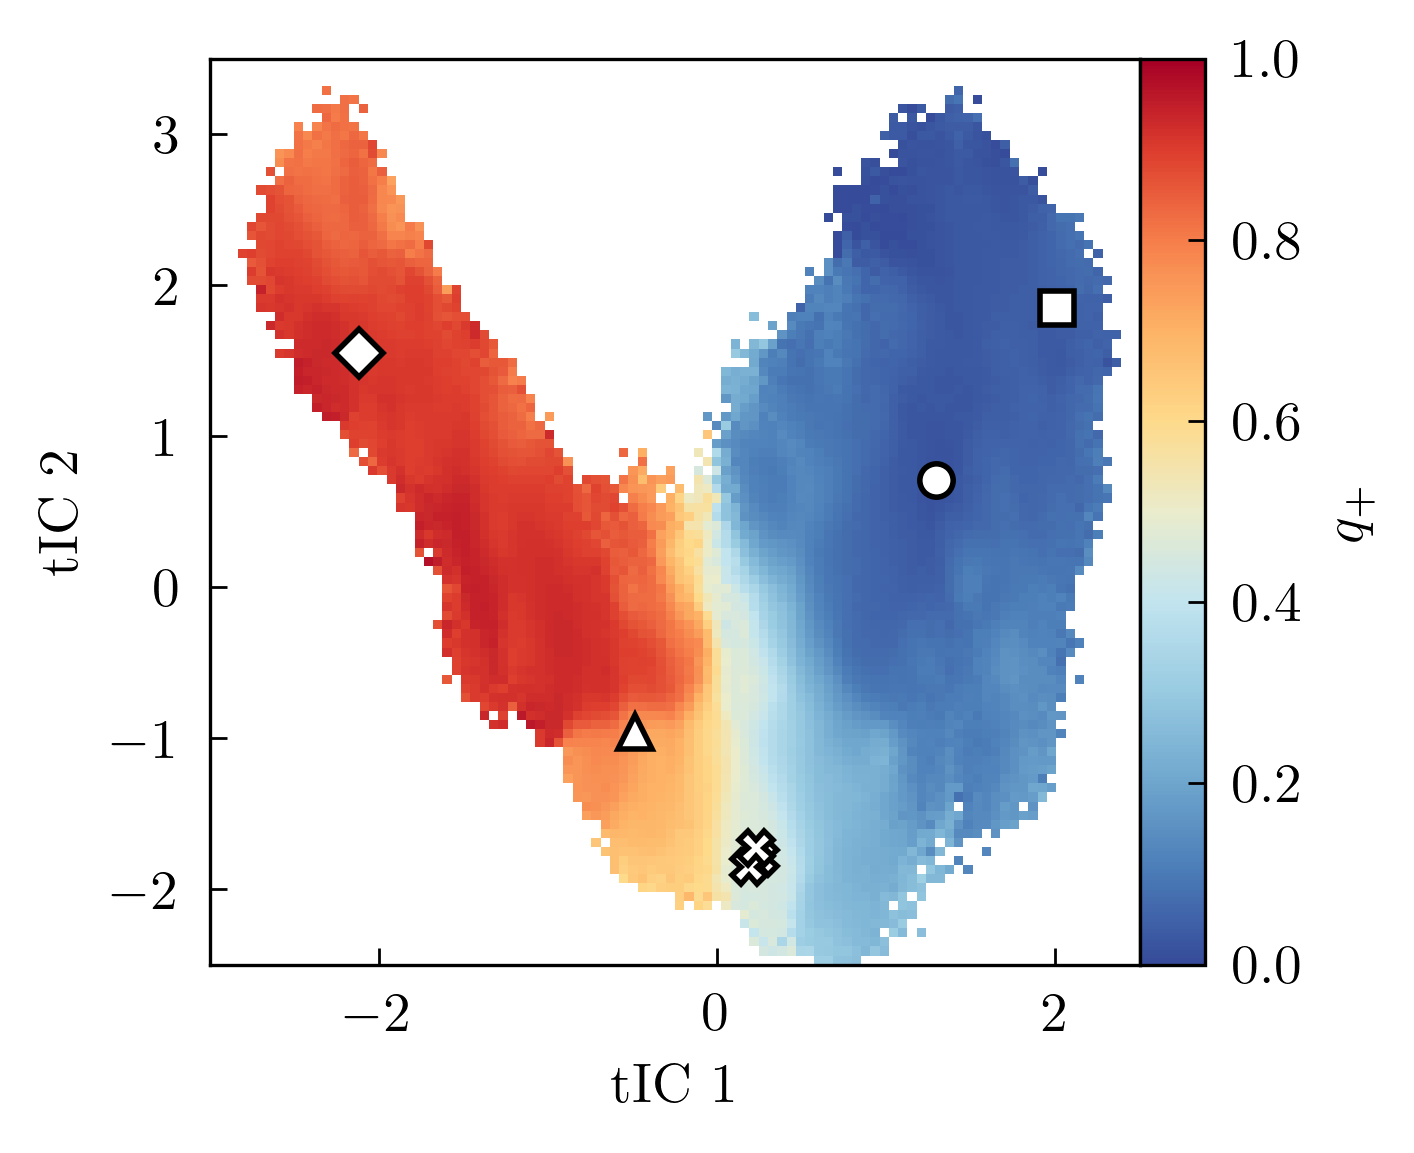

In [40]:
# plot medoids on 
# medoid1_id = 3_000_000 + (103 - 3) * 10001 + 5848
medoid1_id = convert(244, 6580, group="old")
medoid2_id = convert(75, 6847, group="anton2")
medoid3_id = convert(105, 6202, group="anton2")

fig = plt.figure(figsize=(3, 3), dpi=200)

ivac_1 = [t[:, 1] for t in ivac_trajs]
ivac_2 = [t[:, 2] for t in ivac_trajs]
xe = np.linspace(-3, 2.5, 101)
ye = np.linspace(-2.5, 3.5, 101)
q_avg = extq.projection.average2d(ivac_1, ivac_2, qp_du, weights[0], xe, ye)
pc = plt.pcolormesh(xe, ye, q_avg.T, cmap='diverging', vmin=0, vmax=1)
ax = plt.gca()
plotting.plot_models(ax, ivac_models[:, 1:3], ms=6)
plt.plot(*ivac_arr[medoid1_id, 1:3].T, marker='X', mfc='white', mec='black', ms=6)
plt.plot(*ivac_arr[medoid2_id, 1:3].T, marker='X', mfc='white', mec='black', ms=6)
plt.plot(*ivac_arr[medoid3_id, 1:3].T, marker='X', mfc='white', mec='black', ms=6)
plt.xlabel("tIC 1")
plt.ylabel("tIC 2")
pplt.colorbar(pc, label="$q_+$")

## Assign points to medoids

# $k$-means on $X$

In [44]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

In [98]:
k = 2
km = KMeans(n_clusters=k, random_state=123)
km.fit(X[q_inds[0]])
cc = km.cluster_centers_
neighbors = NearestNeighbors(n_neighbors=1)
neighbors.fit(cc)
inds = neighbors.kneighbors(X[q_inds[0]], return_distance=False)

In [58]:
tstate = X[q_inds[0]]

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom


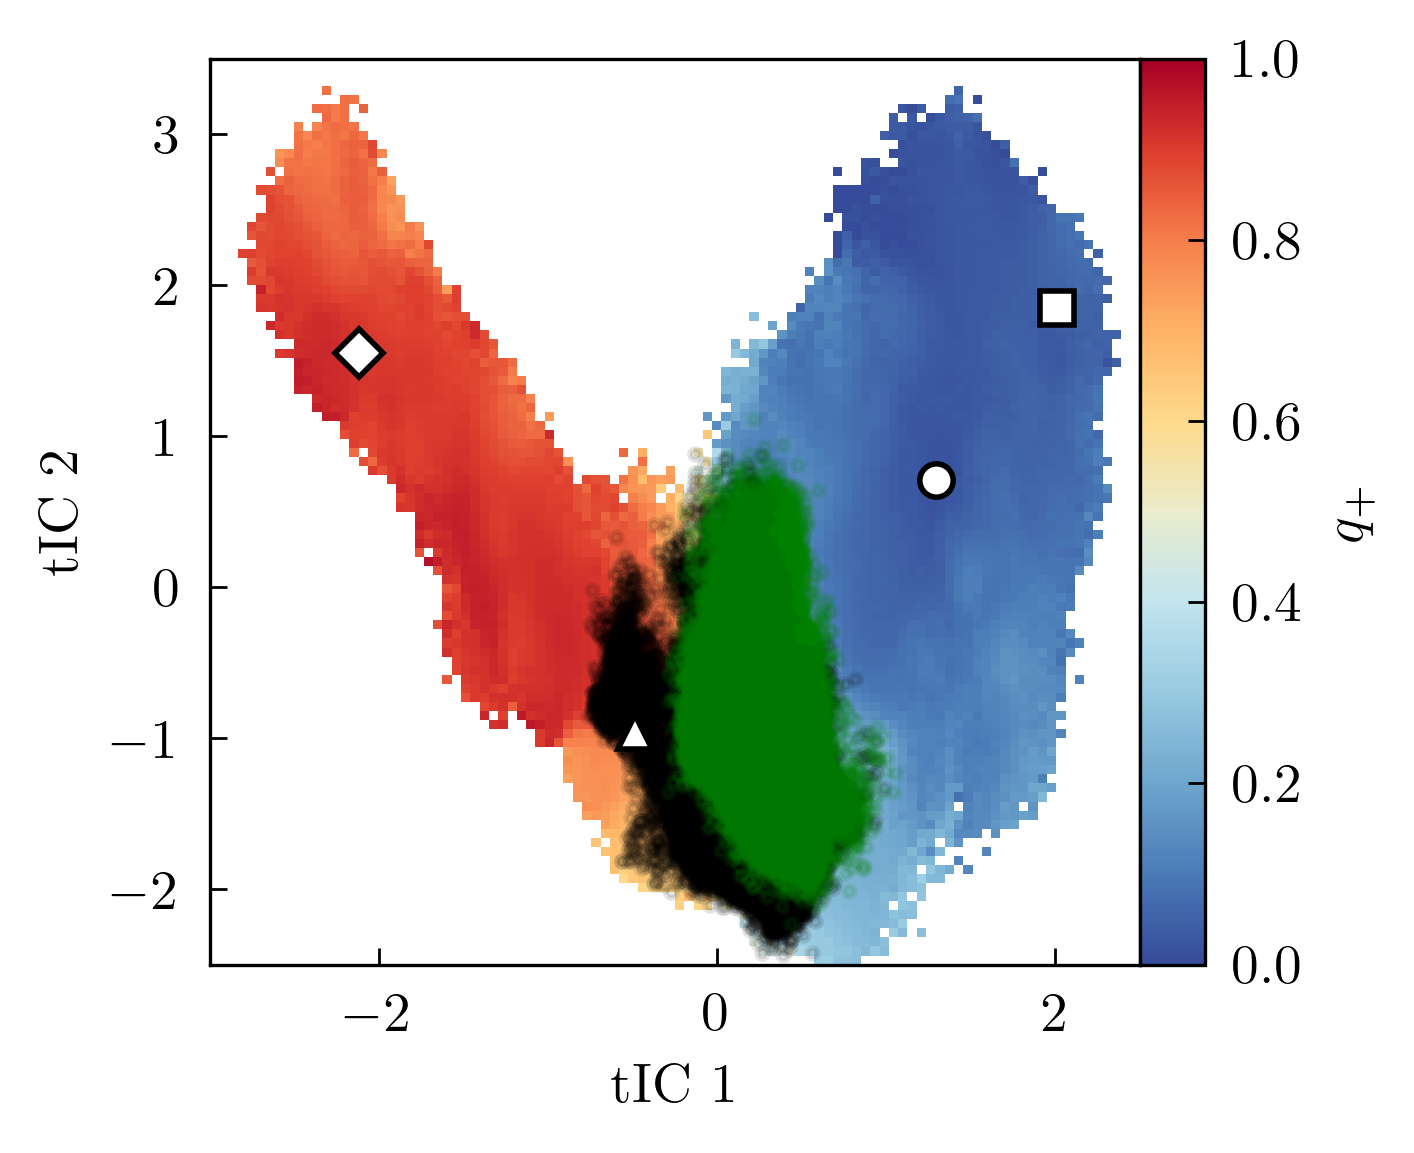

In [99]:
# plot k-means

fig = plt.figure(figsize=(3, 3), dpi=200)

ivac_1 = [t[:, 1] for t in ivac_trajs]
ivac_2 = [t[:, 2] for t in ivac_trajs]
xe = np.linspace(-3, 2.5, 101)
ye = np.linspace(-2.5, 3.5, 101)
q_avg = extq.projection.average2d(ivac_1, ivac_2, qp_du, weights[0], xe, ye)
pc = plt.pcolormesh(xe, ye, q_avg.T, cmap='diverging', vmin=0, vmax=1)
ax = plt.gca()
plotting.plot_models(ax, ivac_models[:, 1:3], ms=6)
cluster1_inds = q_inds[0][(inds == 0).nonzero()[0]]
cluster2_inds = q_inds[0][(inds == 1).nonzero()[0]]
plt.scatter(*ivac_arr[cluster1_inds, 1:3].T, color='black', alpha=0.1, label="Cluster 1")
plt.scatter(*ivac_arr[cluster2_inds, 1:3].T, color='green', alpha=0.1, label="Cluster 2")
# pplt.legend(outside='right', axs=ax)

plt.xlabel("tIC 1")
plt.ylabel("tIC 2")
pplt.colorbar(pc, label="$q_+$")

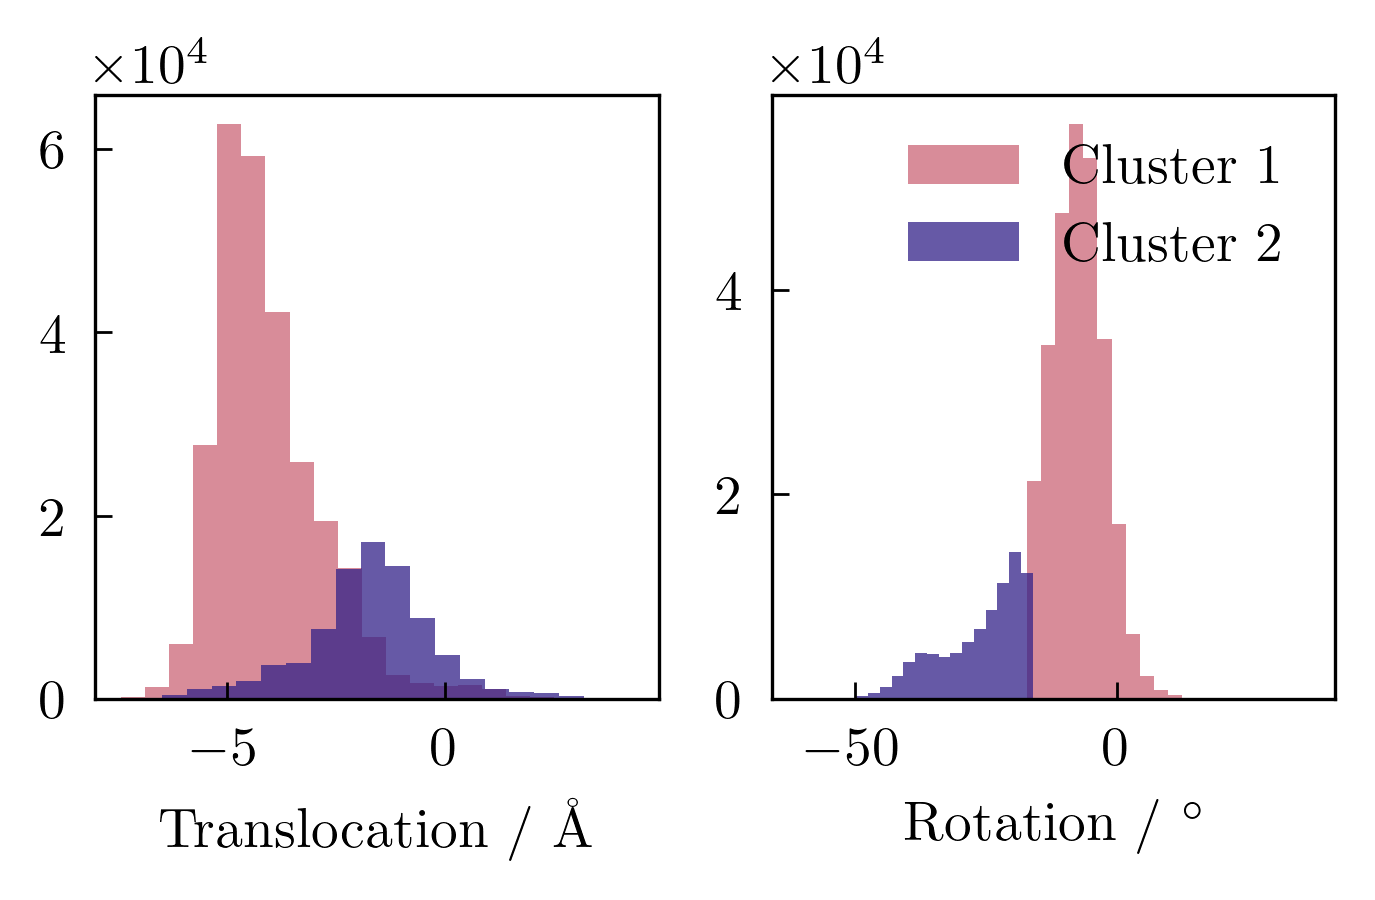

In [100]:
# histogram CVs for each cluster
fig, axs = plt.subplots(1, 2, figsize=(4, 2), dpi=200)
for i, ax in enumerate(axs):
    ax.hist(cv_arr[cluster1_inds, i], bins=20, alpha=0.75, label="Cluster 1")
    ax.hist(cv_arr[cluster2_inds, i], bins=20, alpha=0.75, label="Cluster 2")
axs[0].set_xlabel("Translocation / Å")
axs[1].set_xlabel("Rotation / $^\circ$")
plt.legend()

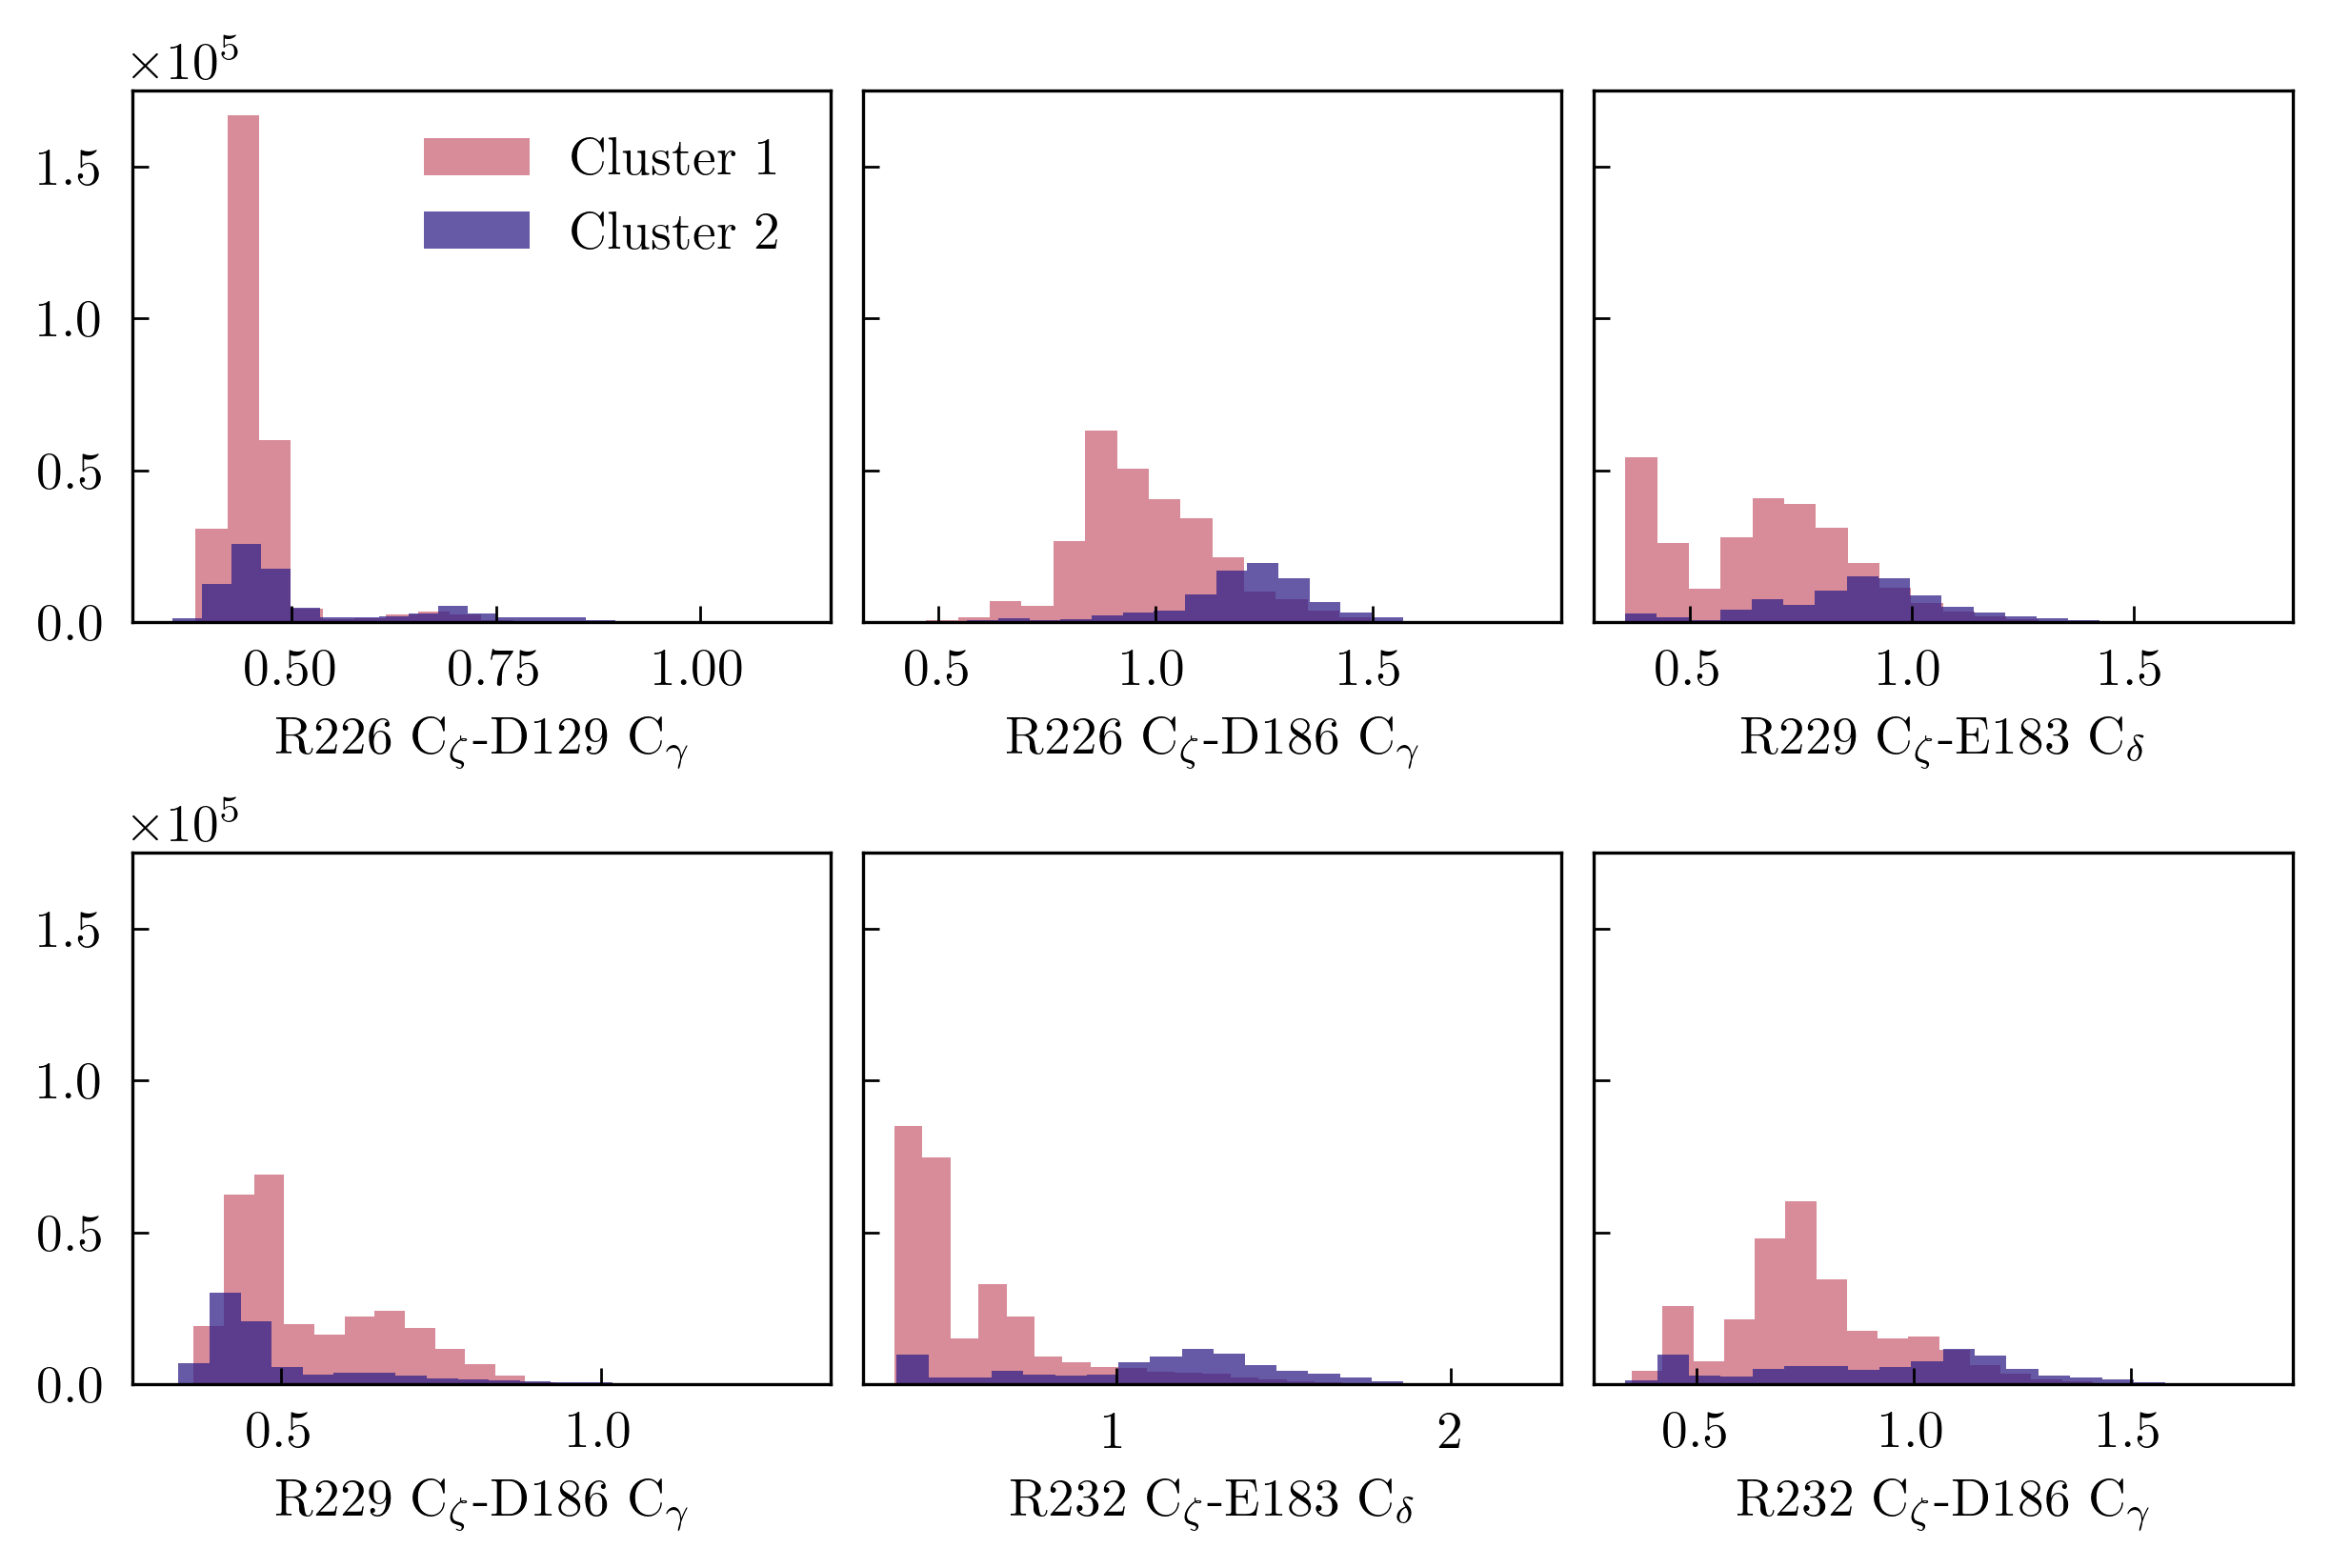

In [101]:
# histogram CVs for each cluster
fig, axs = plt.subplots(2, 3, figsize=(6, 4), dpi=200, sharey=True, constrained_layout=True)
for i in range(len(sb_ids)):
    ax = axs.flat[i]
    ix = sb_ids[i]
    ax.hist(sb_arr[cluster1_inds, ix], bins=20, alpha=0.75, label="Cluster 1")
    ax.hist(sb_arr[cluster2_inds, ix], bins=20, alpha=0.75, label="Cluster 2")
    ax.set_xlabel(sb_names[ix])
axs[0,0].legend()

## $k$ = 3?

In [91]:
k = 3
km = KMeans(n_clusters=k, random_state=123)
km.fit(X[q_inds[0]])
cc = km.cluster_centers_
neighbors = NearestNeighbors(n_neighbors=1)
neighbors.fit(cc)
inds = neighbors.kneighbors(X[q_inds[0]], return_distance=False)

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom


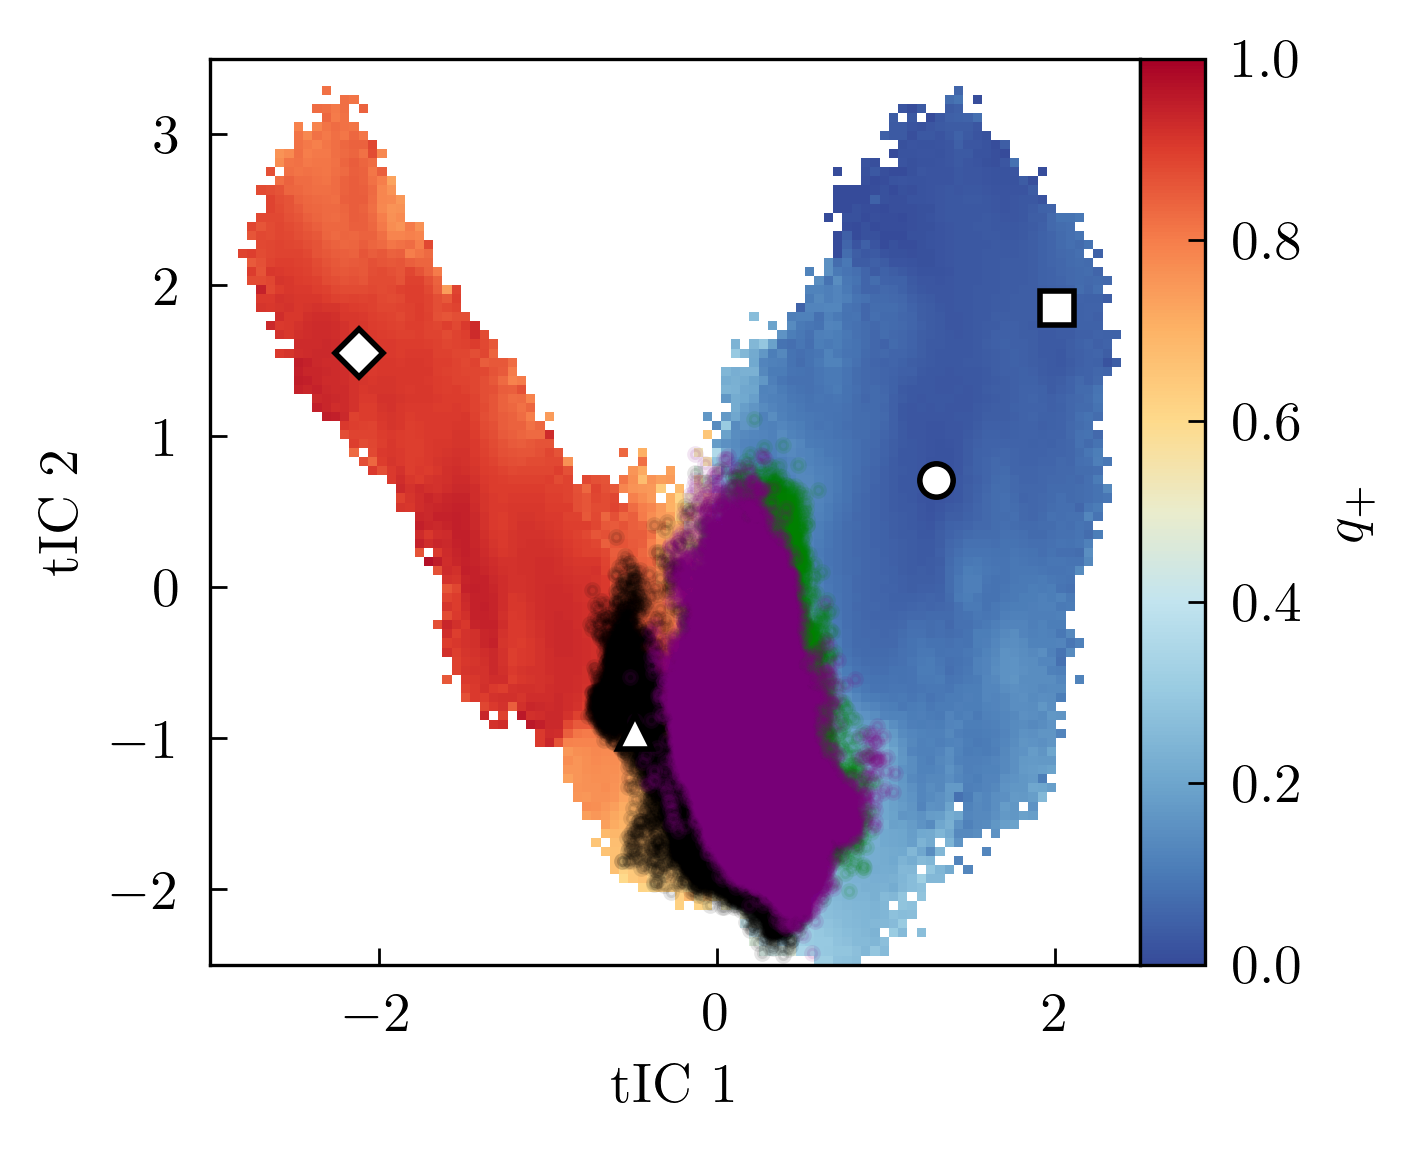

In [92]:
# plot k-means

fig = plt.figure(figsize=(3, 3), dpi=200)

ivac_1 = [t[:, 1] for t in ivac_trajs]
ivac_2 = [t[:, 2] for t in ivac_trajs]
xe = np.linspace(-3, 2.5, 101)
ye = np.linspace(-2.5, 3.5, 101)
q_avg = extq.projection.average2d(ivac_1, ivac_2, qp_du, weights[0], xe, ye)
pc = plt.pcolormesh(xe, ye, q_avg.T, cmap='diverging', vmin=0, vmax=1)
ax = plt.gca()
plotting.plot_models(ax, ivac_models[:, 1:3], ms=6)
cluster1_inds = q_inds[0][(inds == 0).nonzero()[0]]
cluster2_inds = q_inds[0][(inds == 1).nonzero()[0]]
cluster3_inds = q_inds[0][(inds == 2).nonzero()[0]]
plt.scatter(*ivac_arr[cluster1_inds, 1:3].T, color='black', alpha=0.1, label="Cluster 1")
plt.scatter(*ivac_arr[cluster2_inds, 1:3].T, color='green', alpha=0.1, label="Cluster 2")
plt.scatter(*ivac_arr[cluster3_inds, 1:3].T, color='purple', alpha=0.1, label="Cluster 2")
# pplt.legend(outside='right', axs=ax)

plt.xlabel("tIC 1")
plt.ylabel("tIC 2")
pplt.colorbar(pc, label="$q_+$")

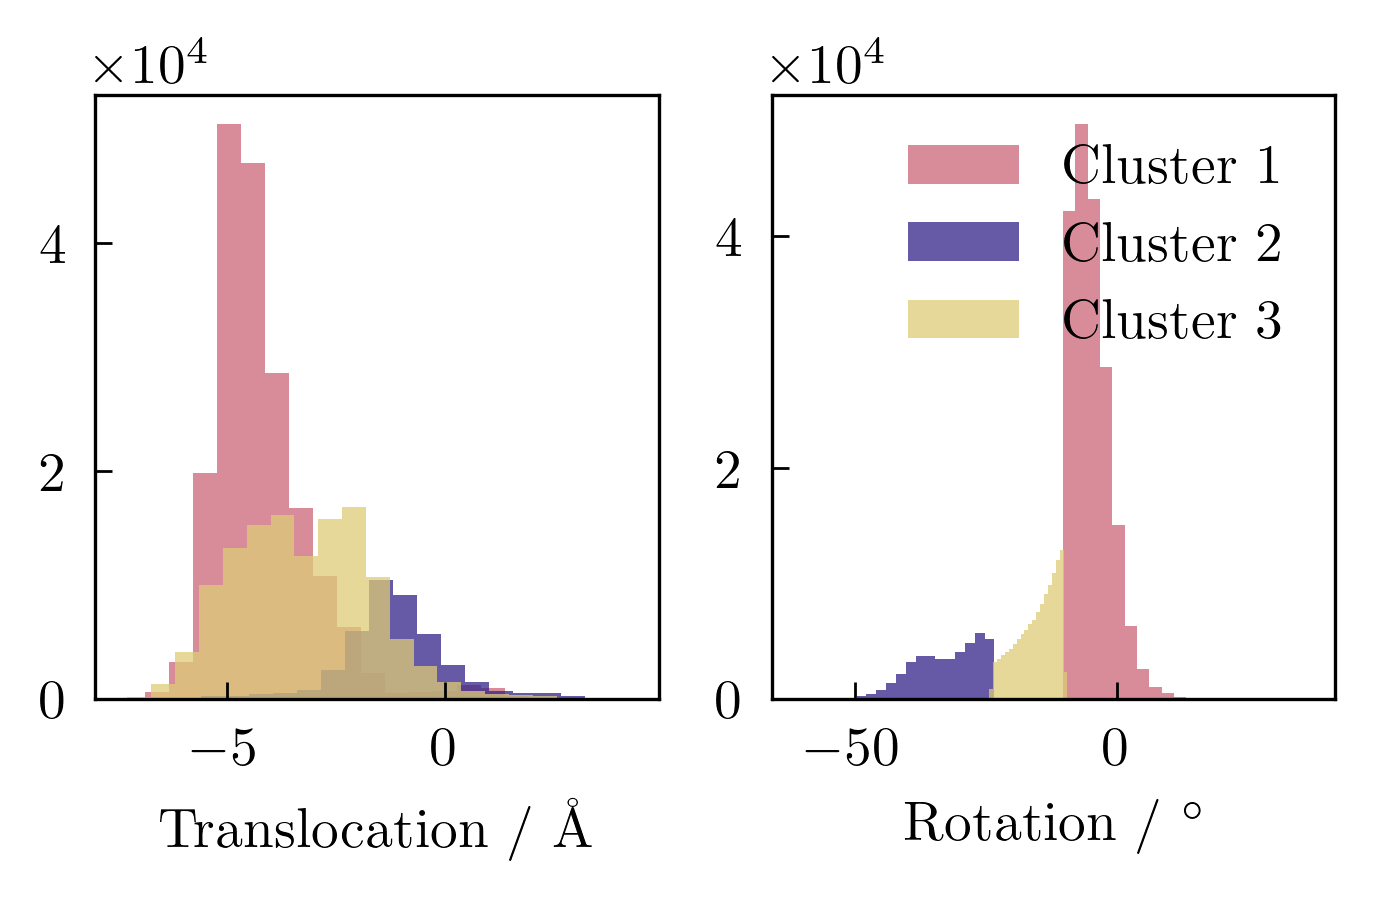

In [93]:
# histogram CVs for each cluster
fig, axs = plt.subplots(1, 2, figsize=(4, 2), dpi=200)
for i, ax in enumerate(axs):
    ax.hist(cv_arr[cluster1_inds, i], bins=20, alpha=0.75, label="Cluster 1")
    ax.hist(cv_arr[cluster2_inds, i], bins=20, alpha=0.75, label="Cluster 2")
    ax.hist(cv_arr[cluster3_inds, i], bins=20, alpha=0.75, label="Cluster 3")
axs[0].set_xlabel("Translocation / Å")
axs[1].set_xlabel("Rotation / $^\circ$")
plt.legend()

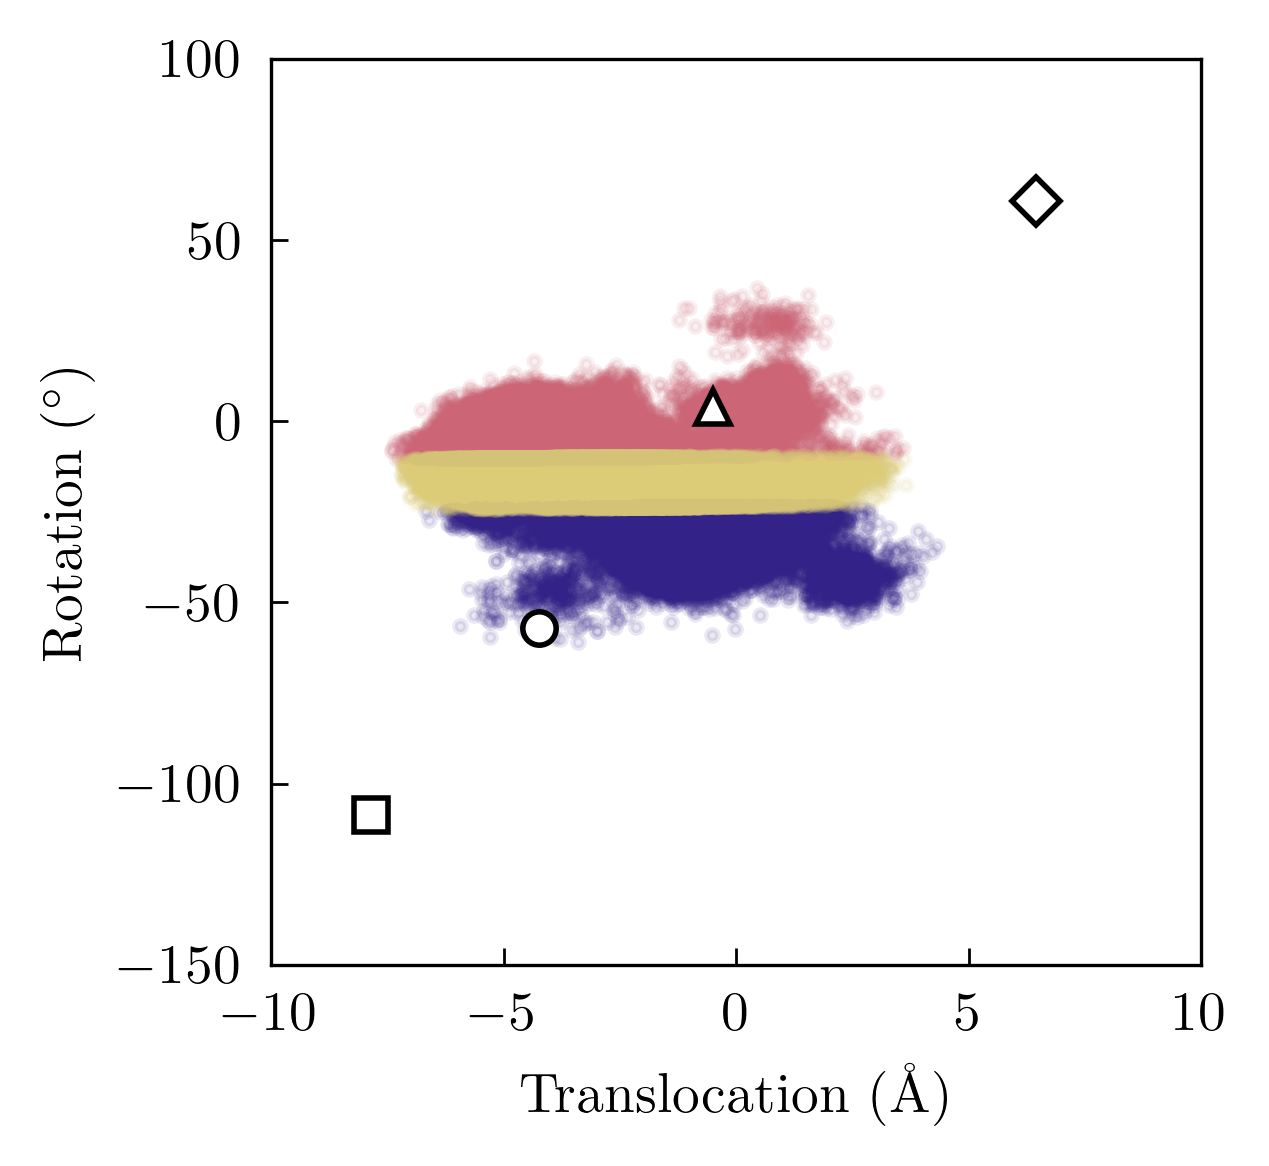

In [96]:
fig = plt.figure(figsize=(3,3), dpi=200)
plt.scatter(cv_arr[cluster1_inds, 0], cv_arr[cluster1_inds, 1], alpha=0.1)
plt.scatter(cv_arr[cluster2_inds, 0], cv_arr[cluster2_inds, 1], alpha=0.1)
plt.scatter(cv_arr[cluster3_inds, 0], cv_arr[cluster3_inds, 1], alpha=0.1)
ax = plt.gca()
plotting.format_cvs(ax, ms=6)

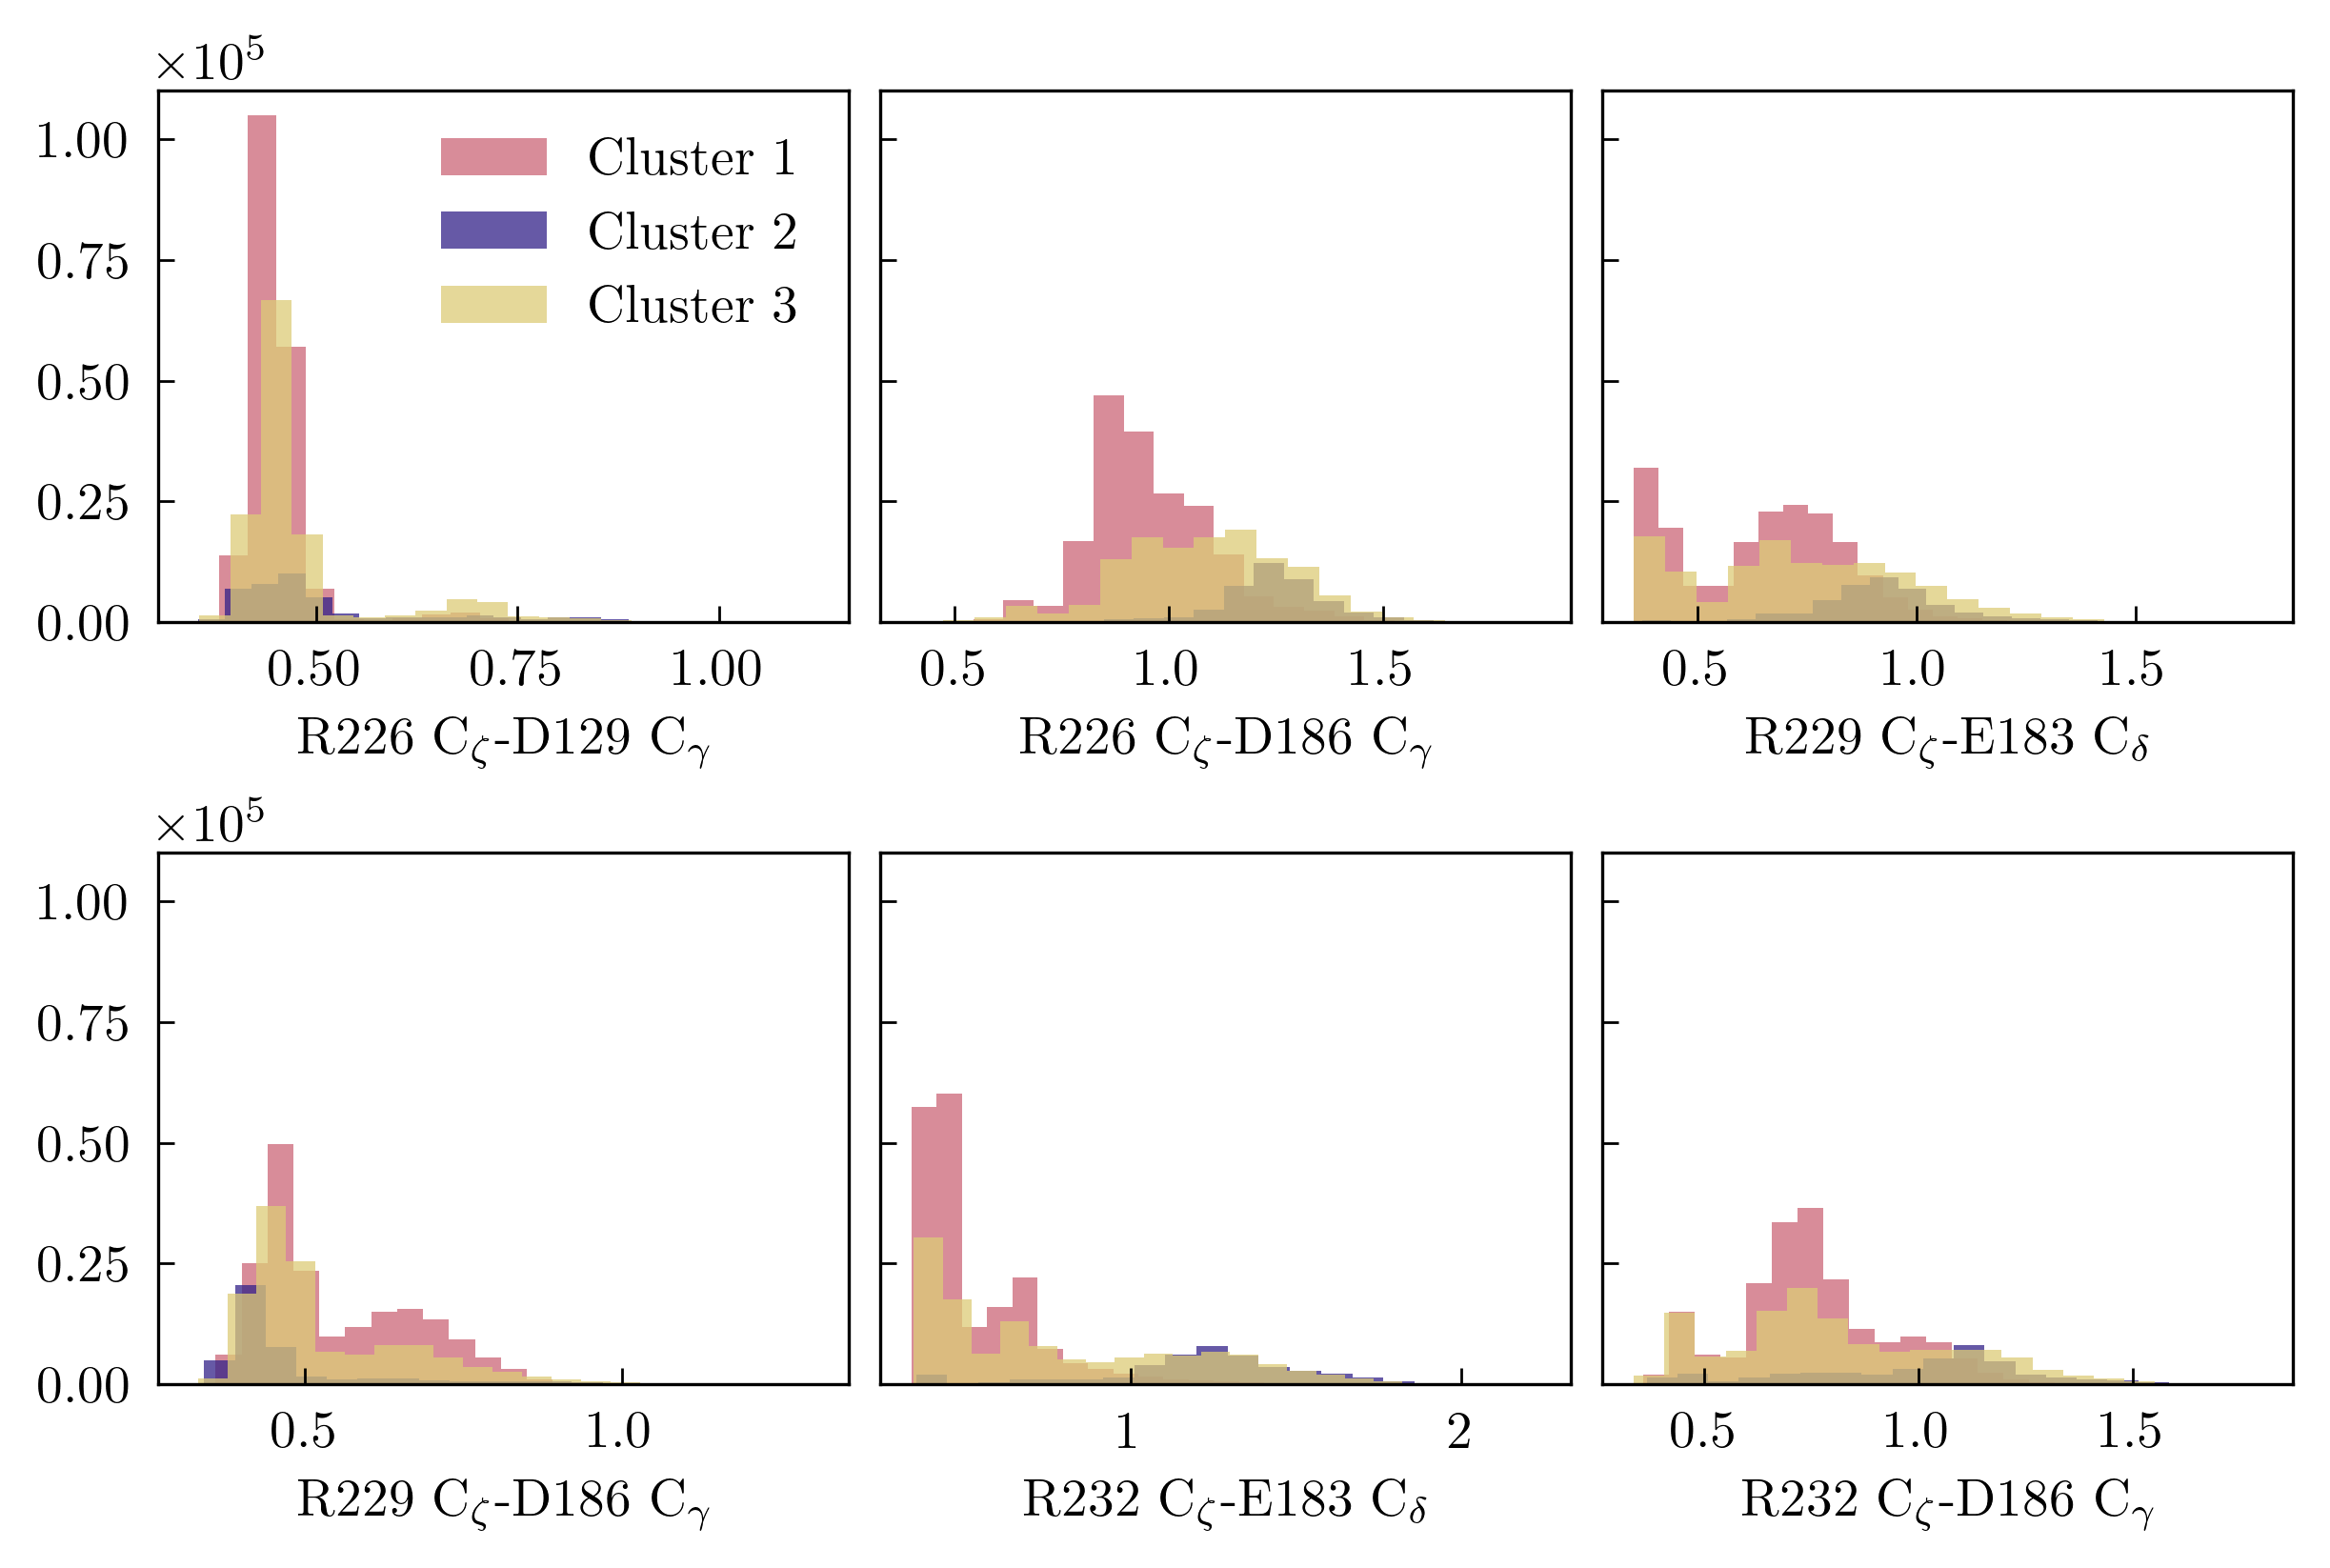

In [97]:
# histogram CVs for each cluster
fig, axs = plt.subplots(2, 3, figsize=(6, 4), dpi=200, sharey=True, constrained_layout=True)
for i in range(len(sb_ids)):
    ax = axs.flat[i]
    ix = sb_ids[i]
    ax.hist(sb_arr[cluster1_inds, ix], bins=20, alpha=0.75, label="Cluster 1")
    ax.hist(sb_arr[cluster2_inds, ix], bins=20, alpha=0.75, label="Cluster 2")
    ax.hist(sb_arr[cluster3_inds, ix], bins=20, alpha=0.75, label="Cluster 3")
    ax.set_xlabel(sb_names[ix])
axs[0,0].legend()

# Hierarchical clustering

In [73]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
ac = AgglomerativeClustering(n_clusters=2, linkage='single')
labels = ac.fit_predict(tstate)
print(ac.n_clusters_)
print(labels)